# Demonstrate How a Normal Distribution Can Occur Naturally
*This notebook shows how error terms that break down as sums of non-normal random variables can be normally distributed.*

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy.optimize import root_scalar
from numpy.polynomial.hermite import hermgauss
from collections import defaultdict
np.random.seed(1)

## Decorator for Vector Functions

In [2]:
def vectorizable(f):
    def f_(x):
        if hasattr(x, '__iter__'):
            return np.array([f(xi) for xi in x])
        return f(x)
    return f_

## Build a Non-Normal Distribution

First, we'll make a cubic spline that gradually transitions between two different linear functions with different slopes.

In [3]:
def compute_spline(fpa, fpb, delta):
    mid = delta / 2
    fpmid = (fpb + fpa) / 2
    b1 = fpa
    d1 = (fpmid - b1)/(3*mid**2)
    
    def q1(x):
        return b1*x + d1*x**3
    def q1p(x):
        return b1 + 3*d1*x**2

    qmid = q1(mid)
    
    b2 = fpb
    d2 = (fpmid - b2) / (3*mid**2)
    a2 = qmid + b2*mid + d2*mid**3
    
    def q2(x):
        return a2 + b2*(x - delta) + d2*(x - delta)**3
    def q2p(x):
        return b2 + 3*d2*(x - delta)**2
    
    def q(x):
        if x < mid:
            return q1(x)
        return q2(x)
    def qp(x):
        if x < mid:
            return q1p(x)
        return q2p(x)
    return q, qp

Second, we'll use the cubic splines to construct a function that transitions between multiple different linear functions.

In [4]:
def make_warp(descriptor, delta=0.5):
    slope = descriptor[0]
    rest = descriptor[1:]
    if not rest:
        return lambda x: x*slope, lambda x: slope
    z, rslope = rest[0]
    r, rp = make_warp([rslope] + rest[1:], delta)
    c = (rslope - slope) / (2 * delta)
    intercept = slope*z + c*delta - r(z)
    q, qp = compute_spline(slope, rslope, delta)
    @vectorizable
    def f(x):
        if x < z - delta:
            return slope * x
        if x > z:
            return r(x) + intercept
        return q(x - (z-delta))+slope*(z - delta)
    @vectorizable
    def fp(x):
        if x < z - delta:
            return slope
        if x > z:
            return rp(x)
        return qp(x - (z-delta))
    return f, fp

## Make a Non-Normal Base Distribution

In [5]:
f, fp = make_warp([0.25, (-1.5, 1), (-0.25, 5)], 1)

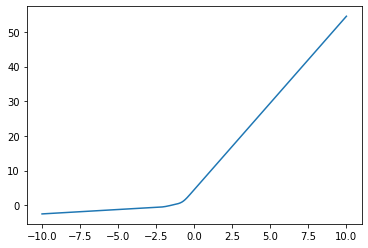

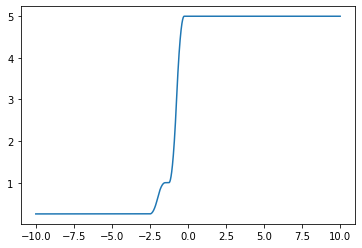

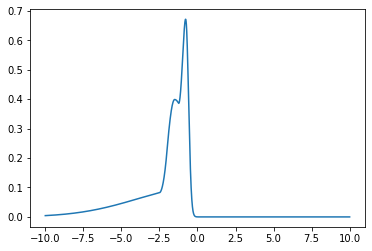

In [6]:
x = np.arange(-10, 10, .0001)
plt.plot(x, f(x))
plt.show()
plt.plot(x, fp(x))
plt.show()
plt.plot(x, norm.pdf(f(x))*fp(x))
plt.show()

## Invert Warping Function

In [7]:
def invert(f, z):
    result = root_scalar(lambda x: f(x) - z, x0=z, x1=z+1)
    return result.root

## Compute Moments of Base Distribution

In [8]:
def compute_moment(f, p=1):
    zx, wx = hermgauss(50)
    c = np.sqrt(2)
    f_inv = lambda z: invert(f, c*z)**p
    result = sum([f_inv(z)*w for z, w in zip(zx, wx)])
    result *= c / np.sqrt(2*np.pi)
    return result

In [9]:
def compute_stddev(f):
    mean = compute_moment(f)
    moment2 = compute_moment(f, 2)
    return moment2 - mean**2

In [10]:
f_volume = compute_moment(f, 0)
f_mean = compute_moment(f, 1)
f_stddev = compute_stddev(f)
print(f_volume, "\t", f_mean, "\t", f_stddev)

1.0 	 -2.226769149373234 	 3.90479258921163


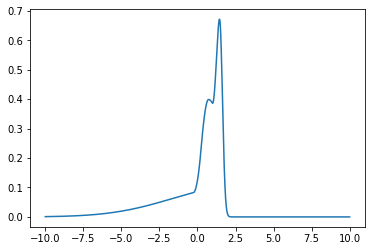

In [11]:
x = np.arange(-10, 10, .0001)
plt.plot(x, norm.pdf(f(x+f_mean))*fp(x+f_mean))

## Sample From Base Distribution

In [12]:
def sample(f, n):
    mean = compute_moment(f)
    zs = np.random.normal(size=n)
    result = np.array([invert(f, z) for z in zs])
    return result

## Compute the Histogram for a Normal Distribution

In [13]:
def compute_normal_histogram(stddev, bin_size):
    a = -3*stddev
    b = 3*stddev
    a = np.floor(a / bin_size)*bin_size
    b = np.ceil(b / bin_size)*bin_size
    num_bins = int(np.rint((b - a) / bin_size))
    bins = np.array(range(num_bins+1))*bin_size + a
    weights = np.zeros(num_bins)
    for i in range(num_bins):
        t = a + bin_size*i
        weights[i] = norm.cdf(t + bin_size, scale=stddev) - norm.cdf(t, scale=stddev)
    return bins, weights

In [14]:
def plot_normal_histogram(stddev, bin_size):
    bins, weights = compute_normal_histogram(stddev, bin_size)
    plt.hist(bins[:-1], bins, weights=weights)

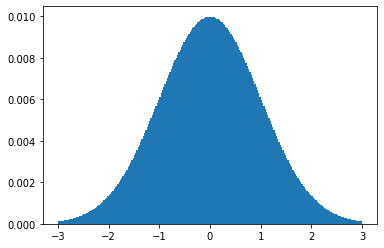

In [15]:
plot_normal_histogram(1.0, 0.025)

## Plot a Histogram With Normal Overlay

In [16]:
def plot_histogram(xs, bin_size, normal_stddev=None, plot=plt):
    a = np.min(xs)
    b = np.max(xs)
    a = np.floor(a / bin_size)*bin_size
    b = np.ceil(b / bin_size)*bin_size
    num_bins = int(np.rint((b - a) / bin_size))
    alpha = 1.0
    if normal_stddev:
        alpha = 0.5
        bins, weights = compute_normal_histogram(normal_stddev, bin_size)
        plot.hist(bins[:-1], bins, weights=weights, alpha=alpha, density=True)
    plot.hist(xs, bins=num_bins, range=(a, b), alpha=alpha, density=True)

## Compute Least Squares Errors

In [17]:
def compute_target(X, b, f, p):
    n = X.shape[0]
    mean = compute_moment(f)
    stddev = compute_stddev(f)
    e = np.zeros(n)
    for _ in range(p):
        ei = sample(f, n)
        e += (ei - mean)
    e /= (np.sqrt(p) * stddev)
    return np.dot(X, b) + e

In [18]:
def compute_least_squares_errors(X_train, X_test, b, f, p):
    y_train = compute_target(X_train, b, f, p)
    y_test = compute_target(X_test, b, f, p)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    rss = np.sum((y_train - y_train_pred)**2)
    noise_var = rss / (X_train.shape[0] - X_train.shape[1])
    y_test_pred = model.predict(X_test)
    return (y_test - y_test_pred), np.sqrt(noise_var)

## Compute Some Error Distributions

In [19]:
N = 20000
b = np.array([-2, 3])
X_train = np.random.uniform(-1, 1, size=(N, len(b)))
X_test = np.random.uniform(-1, 1, size=(N, len(b)))

In [20]:
num_error_terms = [1, 2, 5, 25]
error_data = []
for m in num_error_terms:
    error_data.append(compute_least_squares_errors(X_train, X_test, b, f, m))

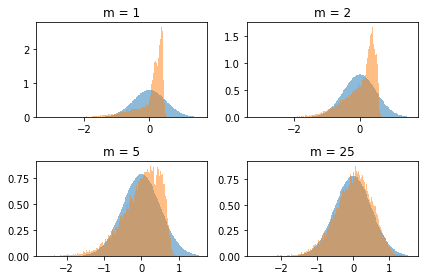

In [21]:
fig, plots = plt.subplots(nrows=2, ncols=2)
index = 0
for i in range(2):
    for j in range(2):
        plot = plots[i, j]
        m = num_error_terms[index]
        errs, noise_stddev = error_data[index]
        plot_histogram(errs, 0.025, noise_stddev, plot)
        plot.set_title('m = %d' % m)
        index += 1
fig.tight_layout()